<img src="images/ntb.png" width="240" height="240" align="left"/>
<div style="text-align: right"> Machine Learning MSE TSM_MachLe <br> FS 2019 <br> 
    <a href="mailto:christoph.wuersch@ntb.ch"> Christoph Würsch </a> </div>

# ML11 A5 Detecting similar Faces using `DBSCAN?

The labelled faces dataset of sckit-learn contains gray scale images of 62 differnet famous personalites
from politics. In this exercise, we assume that there are no target labels, i.e. the names of
the persons are *unknown*. We want to find a method to cluster similar images. This can be done
using a _dimensionality reduction algorithm like PCA_ for feature generation and a subsequent
clustering e.g. using `DBSCAN`.

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
plt.rcParams['image.cmap'] = "gray"

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

### (a) Loading the Faces Dataset

Open the Jupyter notebook `DBSCAN_DetectSimilarFaces.jpynb` and have a look at the
first few faces of the dataset. Not every person is represented equally frequent in this
unbalanced dataset. For classification, we would have to take this into account. We extract
the first 50 images of each person and put them into a flat array called X_people. The
correspinding targets (y-values, names), are storeed in the y_people array.

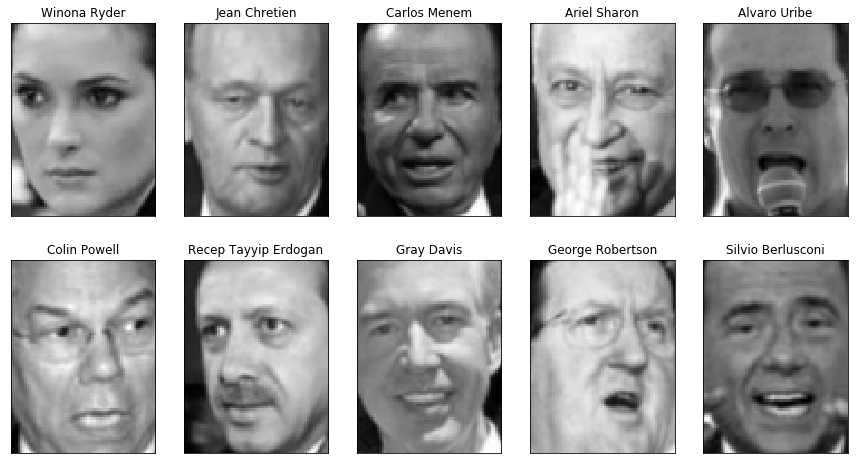

In [6]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [8]:
people.target_names

array(['Alejandro Toledo', 'Alvaro Uribe', 'Amelie Mauresmo',
       'Andre Agassi', 'Angelina Jolie', 'Ariel Sharon',
       'Arnold Schwarzenegger', 'Atal Bihari Vajpayee', 'Bill Clinton',
       'Carlos Menem', 'Colin Powell', 'David Beckham', 'Donald Rumsfeld',
       'George Robertson', 'George W Bush', 'Gerhard Schroeder',
       'Gloria Macapagal Arroyo', 'Gray Davis', 'Guillermo Coria',
       'Hamid Karzai', 'Hans Blix', 'Hugo Chavez', 'Igor Ivanov',
       'Jack Straw', 'Jacques Chirac', 'Jean Chretien',
       'Jennifer Aniston', 'Jennifer Capriati', 'Jennifer Lopez',
       'Jeremy Greenstock', 'Jiang Zemin', 'John Ashcroft',
       'John Negroponte', 'Jose Maria Aznar', 'Juan Carlos Ferrero',
       'Junichiro Koizumi', 'Kofi Annan', 'Laura Bush',
       'Lindsay Davenport', 'Lleyton Hewitt', 'Luiz Inacio Lula da Silva',
       'Mahmoud Abbas', 'Megawati Sukarnoputri', 'Michael Bloomberg',
       'Naomi Watts', 'Nestor Kirchner', 'Paul Bremer', 'Pete Sampras',
       'Rece

In [9]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [10]:
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

In [11]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

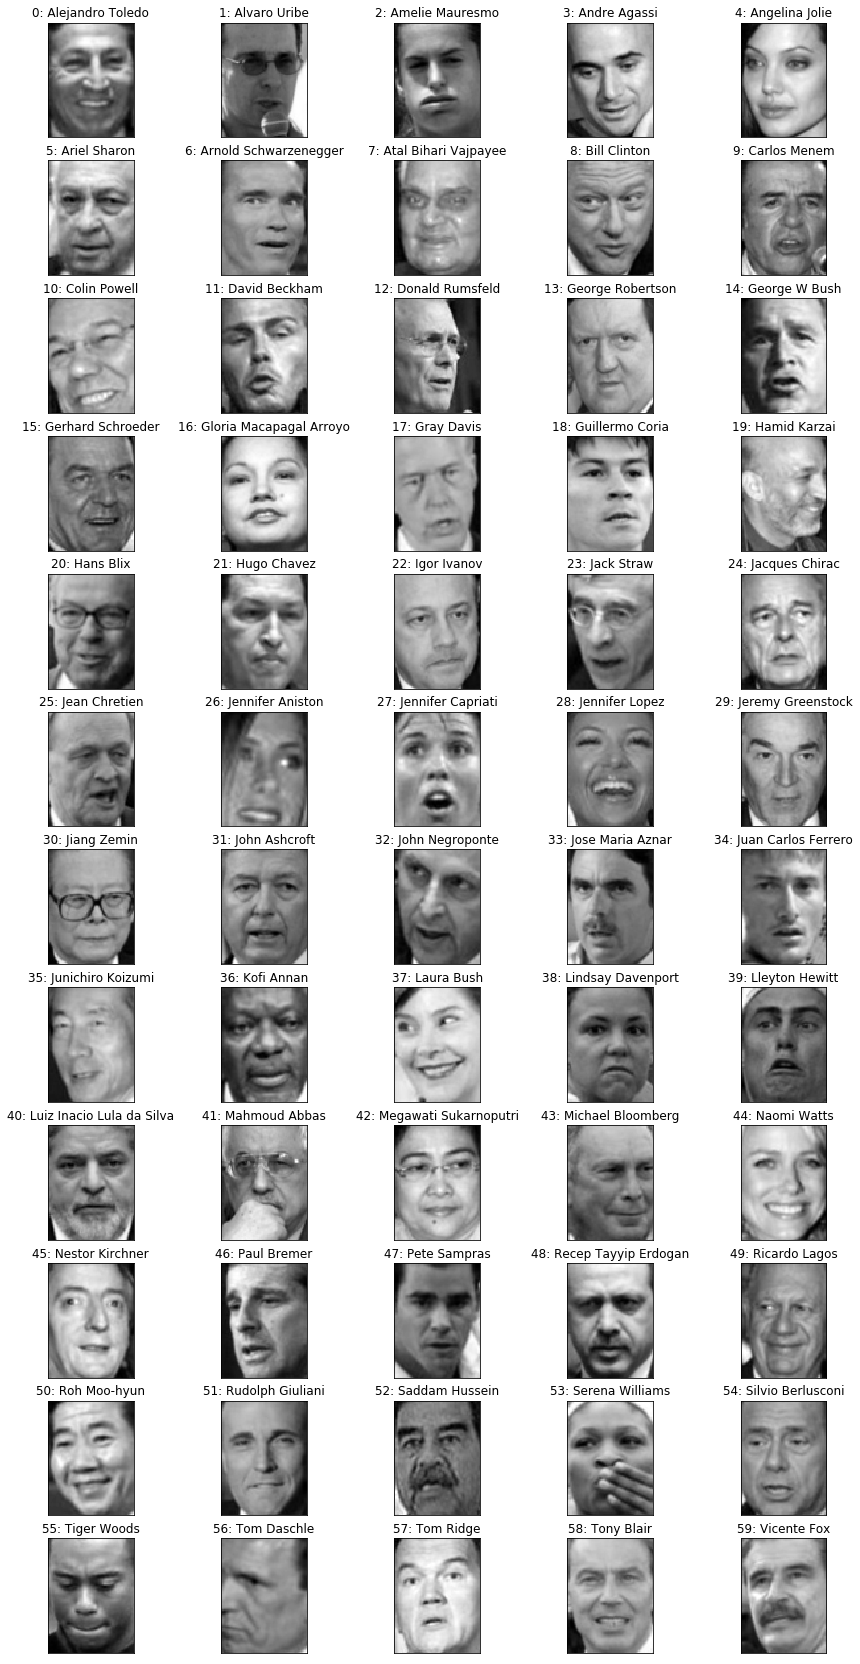

In [12]:
NumberOfPeople=np.unique(people.target).shape[0]
TargetNames  = [];
n=5

#find the first 5 images from each person
fig, axes = plt.subplots(12, 5, figsize=(15, 30),
                         subplot_kw={'xticks': (), 'yticks': ()})

for target,ax in zip(np.unique(people.target),axes.ravel()):
    #get the first n pictures from each person
    indices=np.where(people.target == target)[0][1:n+1]
    TargetNames.append(people.target_names[target])
    
    image=people.images[indices[0]]
    ax.imshow(image)
    ax.set_title(str(target)+': '+TargetNames[target])

    

### (b) Principal Component Analysis

Apply now a principal component analysis `X_pca=pca.fit_transform(X_people)` and
extract the first 100 components of each image. Reconstruct the first 10 entries of the dataset
using the 100 components of the PCA transformed data by applying the
`pca.inverse_transform` method and reshaping the image to the original size using
np.reshape. 

What is the minimum number of components necessary such that you recognize
the persons? Try it out.


In [19]:
NumberOfPeople

62

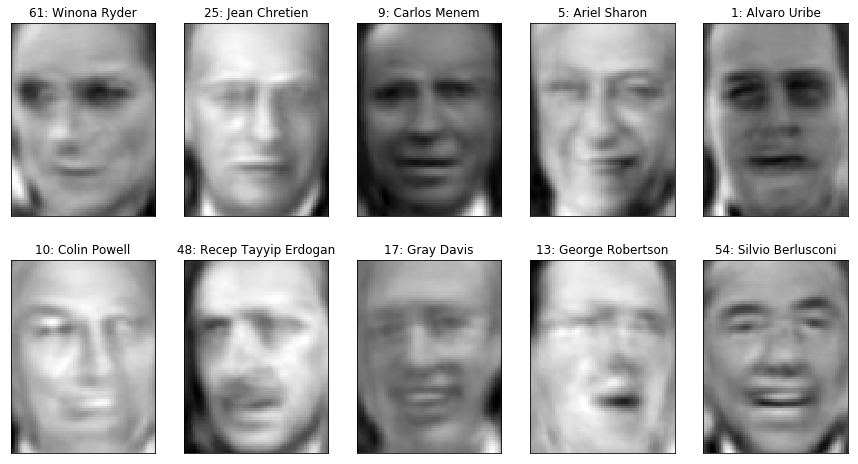

In [20]:
#extract eigenfaces from lfw data and transform data
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
X_pca = pca.fit_transform(X_people)
#X_pca = pca.transform(X_people)

image_shape = people.images[0].shape
NumberOfSamples=X_pca.shape[0]

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})

for ix, target, ax in zip(np.arange(NumberOfSamples), y_people, axes.ravel()):
    image=np.reshape(pca.inverse_transform(X_pca[ix,:]),image_shape)
    ax.imshow(image)
    ax.set_title(str(y_people[ix])+': '+people.target_names[target])


### (c) Apply DBSCAN on these features

Import DBSCAN class from sklearn.cluster, generate an instance called dbscan and
apply it to the pca transformed data X_pca and extract the cluster labels using labels
= dbscan.fit_predict(X_pca). Use first the standard parameters for the method and
check how many unique clusters the algorithm could find by analyzing the number of
unique entries in the predicted cluster labels.

In [21]:
# apply DBSCAN with default parameters
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


### (d) Variation of the `eps` parameter

Change the parameter eps of the dbscan using `dbscan(min_samples=3, eps=5)`. Change
the value of eps in the range from 5 to 10 in steps of 0.5 using a for loop and check for
each value of eps how many clusters could be determined.

In [22]:
for eps in np.linspace(7,8,10):
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=7.0
Number of clusters: 14
Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=7.111111111111111
Number of clusters: 13
Cluster sizes: [1999    4    3   14   13    5    3    4    3    4    5    3    3]

eps=7.222222222222222
Number of clusters: 13
Cluster sizes: [1974   14    3    5   40    3    5    3    4    3    3    3    3]

eps=7.333333333333333
Number of clusters: 12
Cluster sizes: [1956   69    3    7    3    6    3    4    3    3    3    3]

eps=7.444444444444445
Number of clusters: 15
Cluster sizes: [1931   81    6    4    7    4    3    3    4    4    3    4    3    3
    3]

eps=7.555555555555555
Number of clusters: 14
Cluster sizes: [1910  100   12    5    3    5    3    3    4    5    3    4    3    3]

eps=7.666666666666667
Number of clusters: 11
Cluster sizes: [1866  161    4    4    3    8    3    3    3    3    5]

eps=7.777777777777778
Number of clusters: 8
Cluster sizes: [1828  213    4    4    3    3    3    5]

eps=7.888

### (e) Maxumum number of clusters found

Select the value of `eps` where the numbers of clusters found is maximum and plot the
members of the clusters found using the follwing python code.

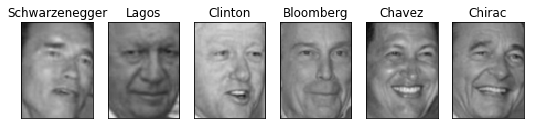

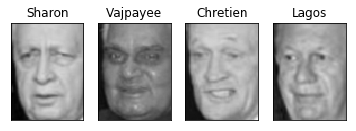

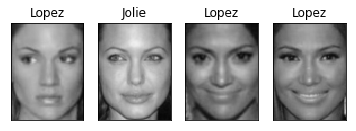

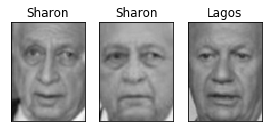

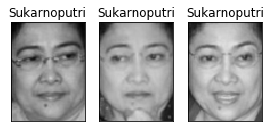

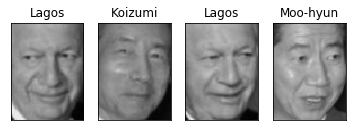

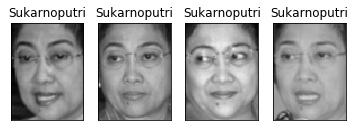

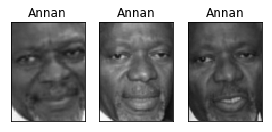

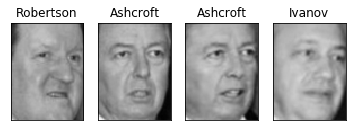

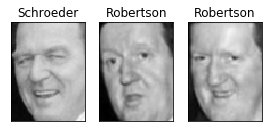

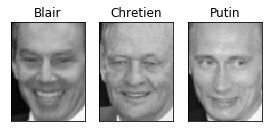

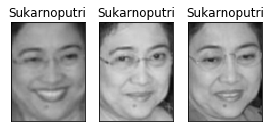

In [23]:
dbscan = DBSCAN(min_samples=3, eps=7.44)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images =  np.sum(mask)
    if n_images<7:
        fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
        for image, label, ax in zip(X_people[mask], y_people[mask], axes):

            ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
            ax.set_title(people.target_names[label].split()[-1])

# Bonus: Agglomerative and Spectral Clustering (optional)

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
          gamma=1.0, kernel_params=None, n_clusters=14, n_init=10,
          n_jobs=None, n_neighbors=10, random_state=None)
SpectralClustering: 1.9 sec
labels found: 14
_____________________________________________
       SpectralClustering                                     
_____________________________________________
max image: 8



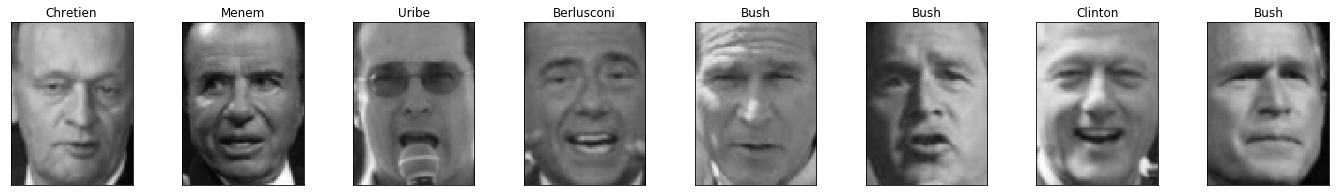

max image: 8



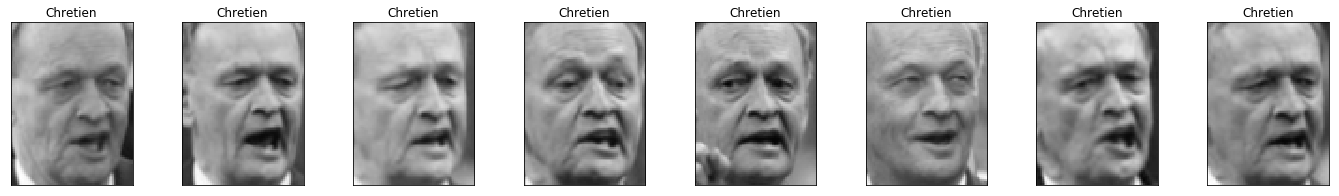

max image: 8



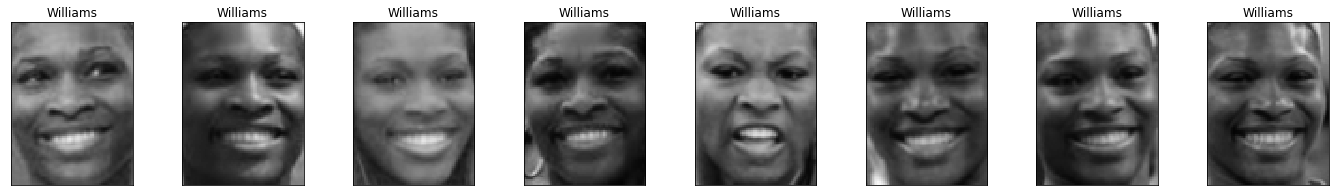

max image: 8



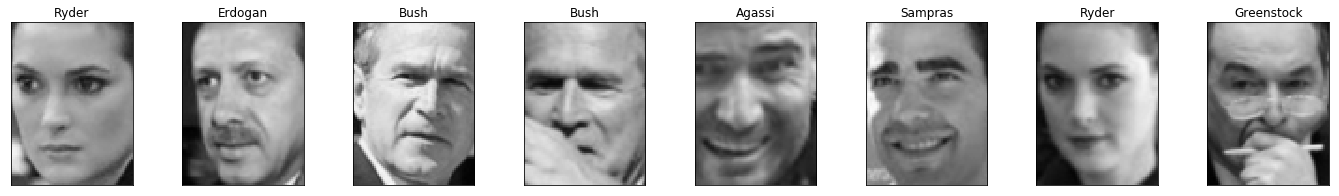

max image: 8



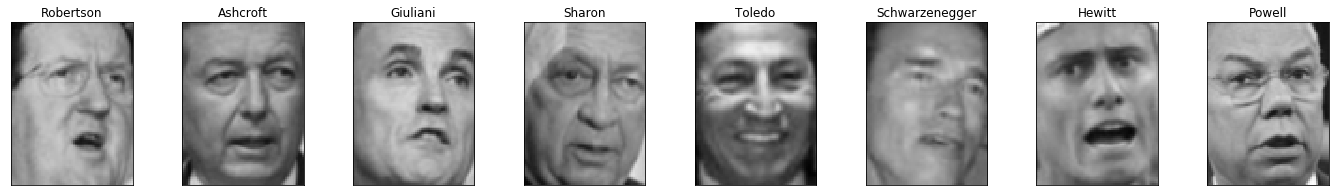

max image: 8



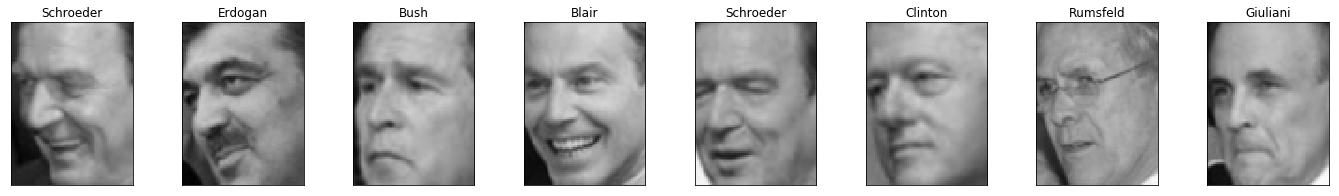

max image: 8



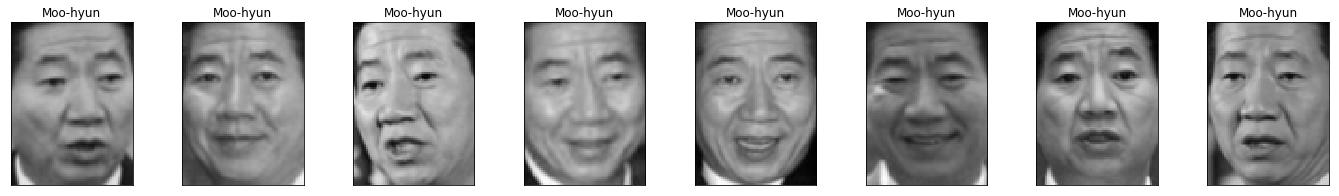

max image: 8



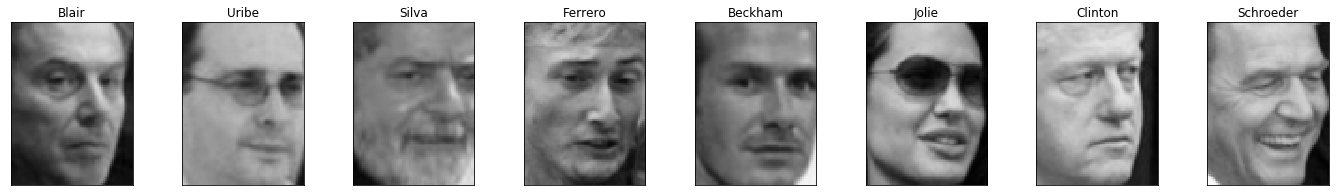

max image: 8



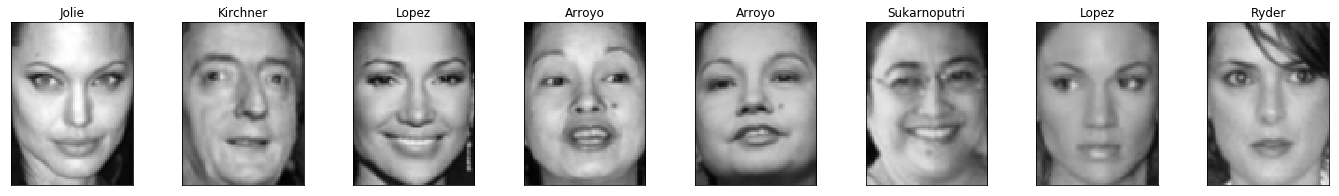

max image: 8



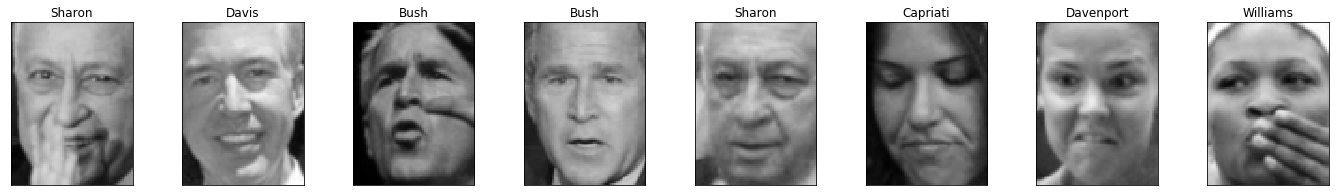

max image: 8



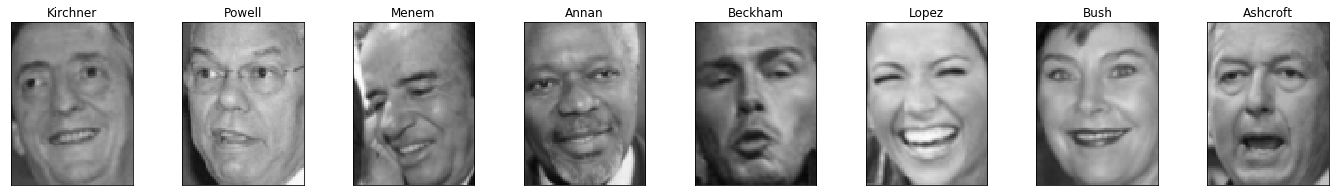

max image: 8



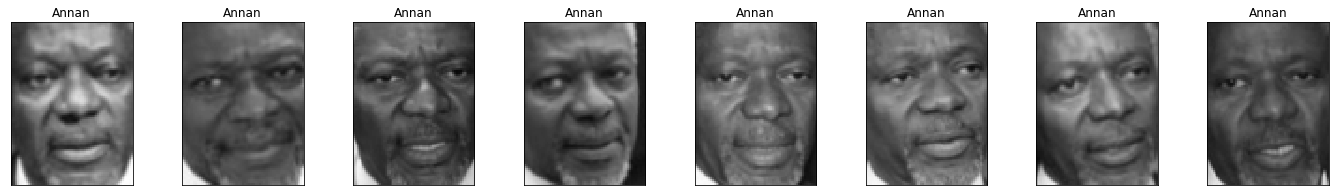

max image: 8



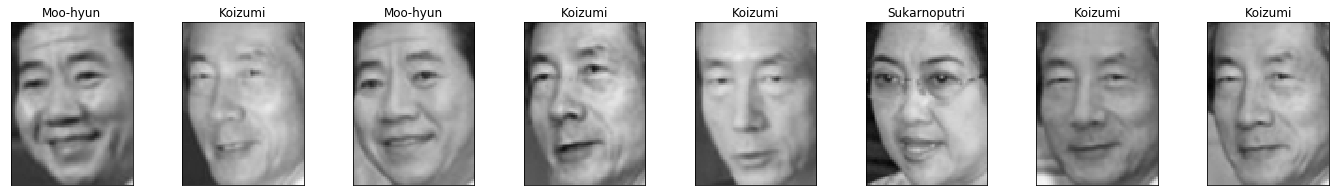

max image: 8



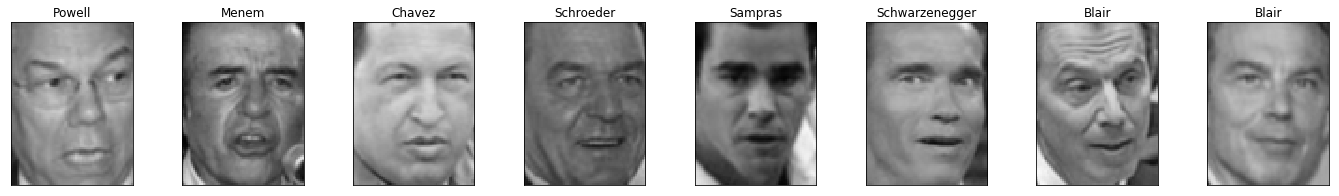

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<2063x2063 sparse matrix of type '<class 'numpy.float64'>'
	with 53332 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=14,
            pooling_func='deprecated')
Ward: 1.1 sec
labels found: 14
_____________________________________________
       Ward                                     
_____________________________________________
max image: 8



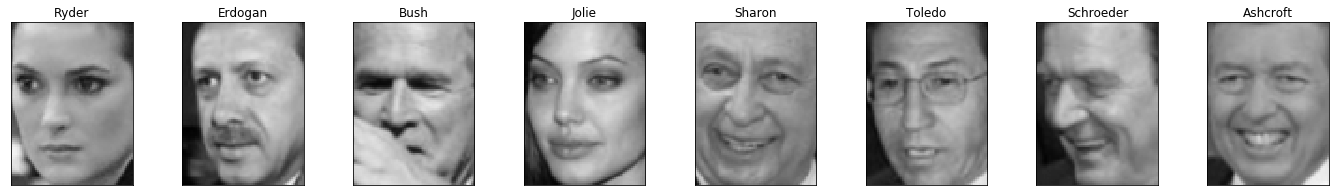

max image: 8



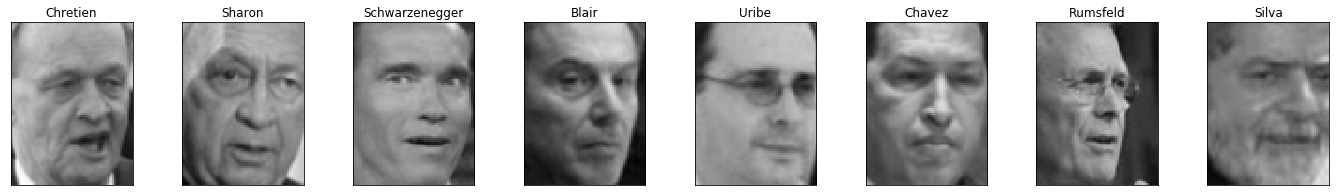

max image: 8



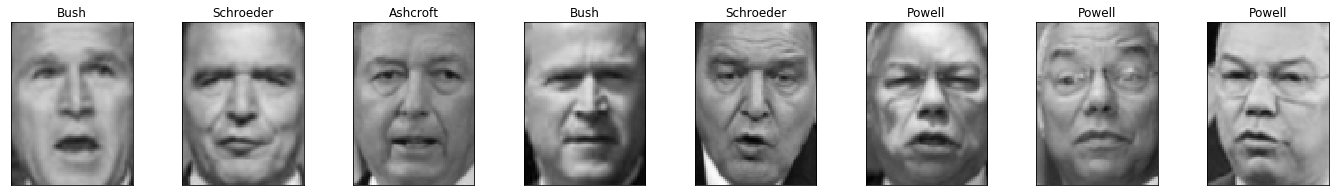

max image: 8



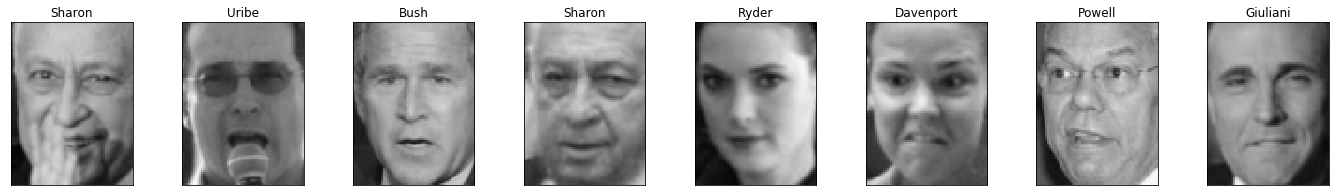

max image: 8



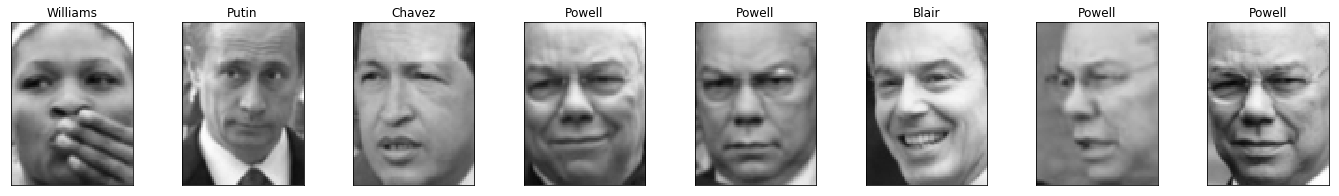

max image: 8



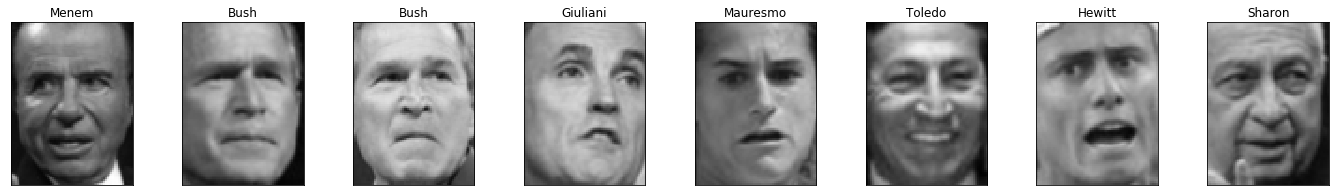

max image: 8



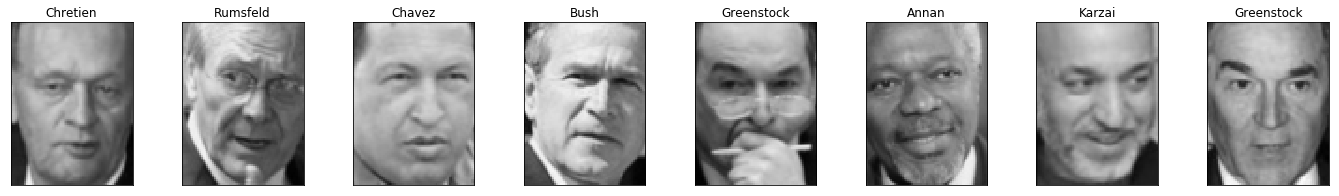

max image: 8



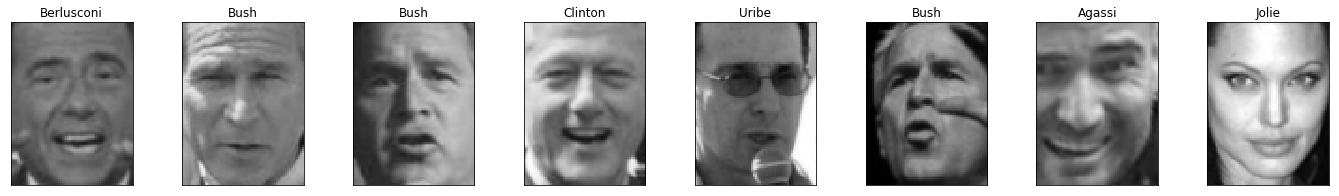

max image: 8



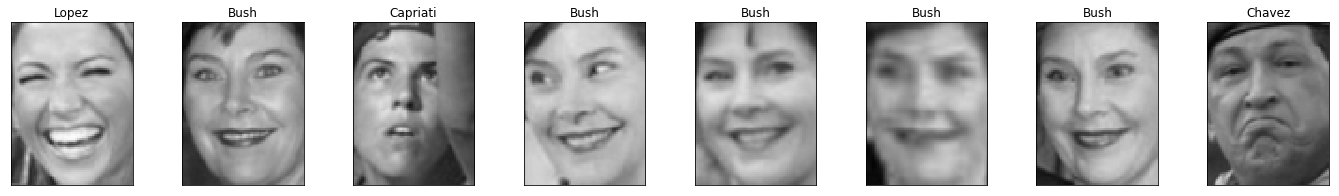

max image: 8



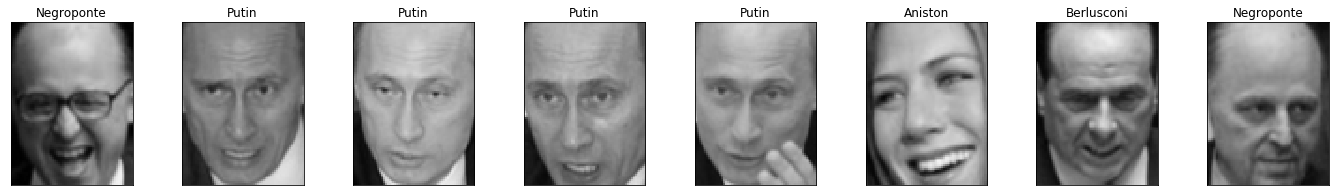

max image: 8



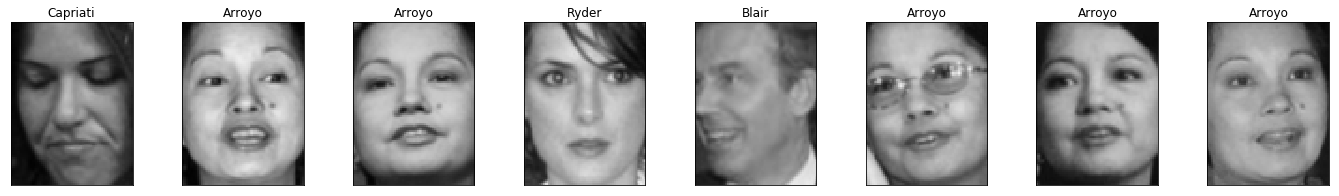

max image: 8



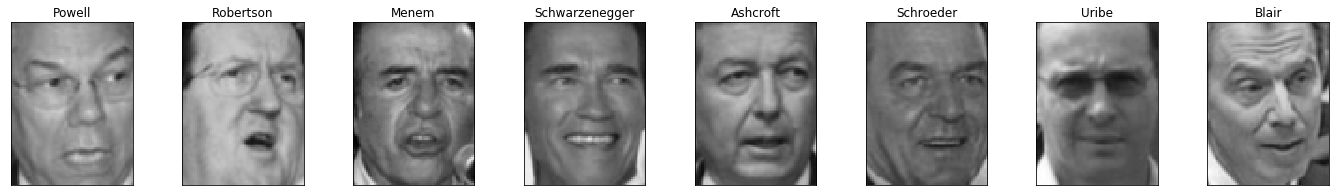

max image: 8



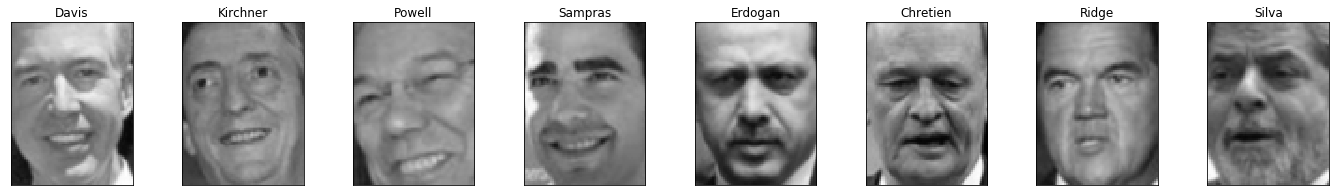

max image: 8



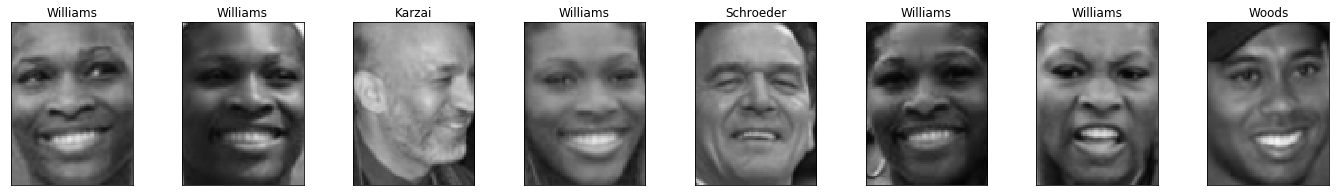

AgglomerativeClustering(affinity='cityblock', compute_full_tree='auto',
            connectivity=<2063x2063 sparse matrix of type '<class 'numpy.float64'>'
	with 53332 stored elements in Compressed Sparse Row format>,
            linkage='average', memory=None, n_clusters=14,
            pooling_func='deprecated')
AverageLinkage: 3.3 sec
labels found: 14
_____________________________________________
       AverageLinkage                                     
_____________________________________________
max image: 8



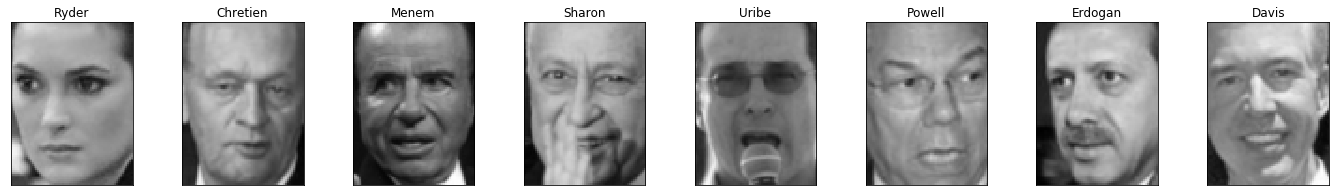

max image: 1

1989


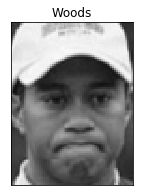

max image: 2



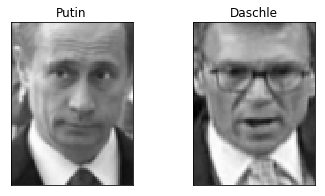

max image: 1

1606


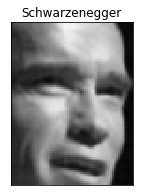

max image: 1

1881


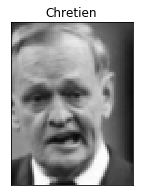

max image: 1

1982


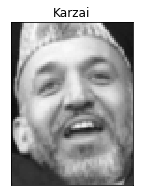

max image: 2



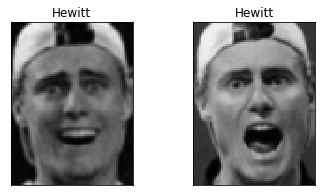

max image: 1

627


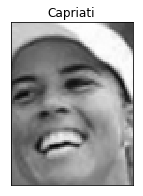

max image: 1

1090


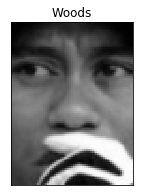

max image: 1

1507


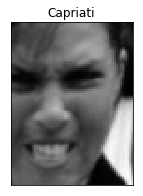

max image: 1

595


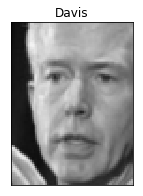

max image: 1

661


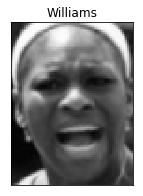

max image: 1

1543


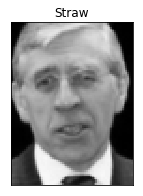

max image: 1

1219


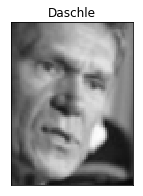

In [24]:
# %% using other cluster algorithms learner on the pca transformed data
from time import time
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

n_clusters=14

clustering_names = ['SpectralClustering', 'Ward', 'AverageLinkage']

connectivity = kneighbors_graph(X_pca, n_neighbors=n_clusters, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")

ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage='ward',
                                           connectivity=connectivity)

average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=n_clusters,
        connectivity=connectivity)


clustering_algorithms = [spectral, ward, average_linkage]

# %matplotlib inline
for name, algorithm in zip(clustering_names, clustering_algorithms):
    # predict cluster memberships
    print(algorithm)
    t0 = time()
    algorithm.fit(X_pca)
    t1 = time()
        
    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_.astype(np.int)
    else:
        labels = algorithm.predict(X_pca)
    
    print("%s: %.2g sec" % (name,t1 - t0))
    print('labels found: %i' % (max(labels) + 1))
    print("_____________________________________________")
    print("       %s                                     " % (name))
    print("_____________________________________________")
    
    for cluster in range(max(labels) + 1):
        mask = labels == cluster
        ind=np.where(mask==True)[0]
        n_images = np.size(ind)
        submask=np.zeros(X_pca.shape[0])
        submask=submask.astype(dtype=bool)
        submask[ind]=True
        #n_images =  np.sum(mask)
        #print(n_images)
            
        max_image=np.min([n_images,8])
        print('max image: %i\n' % (max_image))
        fig, axes = plt.subplots(1, max_image, figsize=(max_image * 3, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})
        
        if max_image==1:
            print(ind[0])
            image=X_people[ind[0]]
            label=y_people[ind[0]]
            plt.imshow(image.reshape(image_shape), vmin=0, vmax=1)
            plt.title(people.target_names[label].split()[-1])
        else:
            for image, label, ax in zip(X_people[submask], y_people[submask], axes):
                ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
                ax.set_title(people.target_names[label].split()[-1])
        
        plt.show()